# RQ 1.2

## Prerequisites: Evaluation Data
as part of the setup, we assume the stargan-v2 data is available under the following path:
- `src/cycle-diffusion/stargan-v2/data/test`

## Input Image ($x$) Perturbations: Rotation and Horizontal Flip

In [10]:
!pwd

/home/lcur1732/cycle-diffusion-group12


## Prepare the data

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from PIL import Image
import os, os.path
from pathlib import Path

def load_data(path):
    imgs = []
    valid_images = [".jpg",".gif",".png",".tga"]
    # for f in os.listdir(path):
    for f in path.iterdir():
        ext = f.suffix
        
        if ext not in valid_images:
            print(f"Skipping {f} because it is not a valid image")
            continue
        imgs.append(Image.open(os.path.join(path,f)))
        print(f"Loaded {f}")

    return imgs

def horizontal_flip(img):
    path, name  = Path(img.filename).parents[0], Path(img.filename).stem
    new_name = f'{name}rotated0flipped.png'
    
    img2 = img.transpose(Image.FLIP_LEFT_RIGHT)
    img2.save(path / new_name)
    
def rotate_and_save(img, angle):
    path, name  = Path(img.filename).parents[0], Path(img.filename).stem
    new_name = f'{name}rotated{str(angle)}.png'
    
    padded = np.pad(img, pad_width=((128, 128), (128, 128), (0, 0)), mode='symmetric')
    padded = Image.fromarray(padded)
    
    img2 = padded.rotate(angle)
    
    width, height = img2.size
    new_width, new_height = 512, 512
    
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    
    img2 = img2.crop((left, top, right, bottom)) # standard resize because images are 512x512

    img2.save(path / new_name)

def save_image_perturbations(imgs, angles=[0, 1, 5, 10, 30, 45, 90]):
    """
    Best variant using padding, other variants see below.
    """
    
    for img in imgs:
        # horizontal flip, and saving 
        horizontal_flip(img) 
            
        # rotations
        for angle in angles:
            rotate_and_save(img, angle)
        


cwd = os.getcwd() # should be cycle-diffusion-group12 folder, otherwise change this
print(f'BASE_DIR: {cwd}, should be the cycle-diffusion-group12 folder')

BASE_DIR = Path(cwd)

cat_path = BASE_DIR / 'src/cycle-diffusion/stargan-test2/data/test/cat'
dog_path = BASE_DIR / 'src/cycle-diffusion/stargan-test2/data/test/dog'
wild_path = BASE_DIR / 'src/cycle-diffusion/stargan-test2/data/test/wild'

cat_dataset = load_data(cat_path) 
dog_dataset = load_data(dog_path)
wild_dataset = load_data(wild_path) 

len(cat_dataset), len(dog_dataset), len(wild_dataset)

BASE_DIR: /home/lcur1732/cycle-diffusion-group12, should be the cycle-diffusion-group12 folder
Loaded /home/lcur1732/cycle-diffusion-group12/src/cycle-diffusion/stargan-test2/data/test/cat/flickr_cat_000008.png
Loaded /home/lcur1732/cycle-diffusion-group12/src/cycle-diffusion/stargan-test2/data/test/dog/flickr_dog_000054.png
Loaded /home/lcur1732/cycle-diffusion-group12/src/cycle-diffusion/stargan-test2/data/test/wild/flickr_wild_000004.png


(1, 1, 1)

In [12]:
all_three = [cat_dataset, dog_dataset, wild_dataset]
angles = [0, 1, 5, 10, 30, 45, 90] # 0 is the duplicate of the original

# ONLY RUN THIS ONCE
for dataset in all_three:
    save_image_perturbations(dataset, angles=angles)

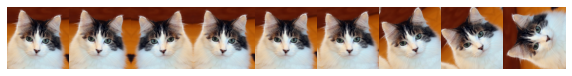

In [14]:
# show the rotated images
fig, axes = plt.subplots(1, 9, figsize=(10, 5))

# Display the first image in the first subplot
img_cat = imread(cat_path / 'flickr_cat_000008.png')
axes[0].imshow(img_cat)
axes[0].axis('off')

# Display the first image in the first subplot
img_cat_org_again = imread(cat_path / 'flickr_cat_000008rotated0.png')
axes[1].imshow(img_cat_org_again)
axes[1].axis('off')

# Display the first image in the first subplot
img_cat_flipped = imread(cat_path / 'flickr_cat_000008rotated0flipped.png')
axes[2].imshow(img_cat_flipped)
axes[2].axis('off')

# Display the second image in the second subplot
img_cat_1 = imread(cat_path / 'flickr_cat_000008rotated1.png')
axes[3].imshow(img_cat_1)
axes[3].axis('off')

# Display the second image in the second subplot
img_cat_5 = imread(cat_path / 'flickr_cat_000008rotated5.png')
axes[4].imshow(img_cat_5)
axes[4].axis('off')

# Display the second image in the second subplot
img_cat_10 = imread(cat_path / 'flickr_cat_000008rotated10.png')
axes[5].imshow(img_cat_10)
axes[5].axis('off')

# Display the second image in the second subplot
img_cat_30 = imread(cat_path / 'flickr_cat_000008rotated30.png')
axes[6].imshow(img_cat_30)
axes[6].axis('off')

# Display the second image in the second subplot
img_cat_45 = imread(cat_path / 'flickr_cat_000008rotated45.png')
axes[7].imshow(img_cat_45)
axes[7].axis('off')

# Display the second image in the second subplot
img_cat_90 = imread(cat_path / 'flickr_cat_000008rotated90.png')
axes[8].imshow(img_cat_90)
axes[8].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Show the figure
plt.show()


### Run cycle diffusion (DDPM)

In [5]:
# using slurm:
# !cd src/cycle-diffusion
# !sbatch test.job

# or from the terminal:
# !export CUDA_VISIBLE_DEVICES=0
# !export RUN_NAME=experiment_test2
# !export SEED=42
# !export LOCAL_RANK=0

# !python -m torch.distributed.launch --nproc_per_node 1 --master_port 1446 main.py --seed $SEED --cfg experiments/$RUN_NAME.cfg --run_name $RUN_NAME$SEED --logging_strategy steps --logging_first_step true --logging_steps 4 --evaluation_strategy steps --eval_steps 50 --metric_for_best_model CLIPEnergy --greater_is_better false --save_strategy steps --save_steps 50 --save_total_limit 1 --load_best_model_at_end --gradient_accumulation_steps 4 --num_train_epochs 0 --adafactor false --learning_rate 1e-3 --do_eval --output_dir output/$RUN_NAME$SEED --overwrite_output_dir --per_device_train_batch_size 1 --per_device_eval_batch_size 1 --eval_accumulation_steps 4 --ddp_find_unused_parameters true --verbose true --custom_z_name rotated_images --disable_wandb True --save_time_steps True


### Calculate Similarity Metrics

In [11]:
# read the z files
import pickle
import numpy as np

z_path = BASE_DIR / 'src/cycle-diffusion/output/experiment_test242/'

all_pickled_zs = [x for x in z_path.iterdir() if x.suffix == '.pickle'] # list of intermediate z "images"

all_np_files = [x for x in z_path.iterdir() if x.suffix == '.npy'] # list of final z vectors

# with open(all_pickled_zs[0], 'rb') as f:
#     zs = pickle.load(f)


z = [np.load(all_np_files[i], 'r') for i in range(len(all_np_files)-4)] # TODO remove -5
print(f'Nr of zs: {len(z)}')
print(f'z[0] shape: {z[0].shape}')
all_z = np.concatenate(z, axis=0)
all_z.shape

Nr of zs: 4
z[0] shape: (1, 167116800)


(4, 167116800)

In [12]:
# cosine similarity
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
dist_out = 1-pairwise_distances(all_z, metric="cosine")


In [13]:
np.set_printoptions(precision=5)
dist_out.shape, dist_out

((4, 4),
 array([[ 1.00000e+00,  1.86643e-02,  3.04389e-03,  1.18673e-04],
        [ 1.86643e-02,  1.00000e+00,  2.98780e-03, -2.39611e-05],
        [ 3.04389e-03,  2.98780e-03,  1.00000e+00,  2.26557e-04],
        [ 1.18673e-04, -2.39611e-05,  2.26557e-04,  1.00000e+00]],
       dtype=float32))

In [15]:
"{:.8f}".format(float("-2.39611e-05"))

'-0.00002396'

: 

# Misc

### Compare images

In [ ]:
# from skimage.metrics import structural_similarity as ssim
# from skimage.transform import resize
# from evaluation.utils import calculate_ssim

# # Load the two RGB images
# image_c = imread("stargan-test/data/test/cat/flickr_cat_000008.png")
# image0c = resize(image_c, (256, 256))

# image_d = imread("stargan-test/data/test/dog/flickr_dog_000054.png")
# image0d = resize(image_d, (256, 256))


# image1 = imread("stargan-test/data/test/0.png")
# image2 = imread("stargan-test/data/test/1.png")

# # Calculate the structural similarity index
# print(calculate_ssim(image_c, image_d))
# print(calculate_ssim(image0c, image1))
# print(calculate_ssim(image0c, image2))
# print(calculate_ssim(image0d, image1))
# print(calculate_ssim(image0d, image2))
# print(calculate_ssim(image1, image2))

# Print the similarity score
# print("Similarity score:", ssim_score)

ModuleNotFoundError: No module named 'evaluation'

## other rotation approaches (not used)

In [ ]:
def crop_image(imgs, angle):
    for image in imgs:
        img = image
        # Rotate the image without cropping and adding black borders
        rotated_image = image.rotate(angle, expand=True, fillcolor='white')
        rotated_image = Image.fromarray(ndimage.zoom(rotated_image, 1.5))
        # Create a blank image with the original dimensions and white background
        output_image = Image.new("RGB", image.size, (255, 255, 255))


        # Paste the rotated image onto the center of the blank image
        x_offset = (output_image.width - rotated_image.width) // 2
        y_offset = (output_image.height - rotated_image.height) // 2
        output_image.paste(rotated_image, (x_offset, y_offset))


        path, name  = Path(img.filename).parents[0], Path(img.filename).stem
        new_name = f'{name}cropped{str(angle)}.png'
        output_image.save(path / new_name)
               
def rotate_image(imgs, angle):
    for img in imgs:
        path, name  = Path(img.filename).parents[0], Path(img.filename).stem
        new_name = f'{name}rotated{str(angle)}.png'
        
        img2 = img.rotate(angle)
        img2.save(path / new_name)
        
        
'''rotated = imread('demos/rotated.jpg')
cropped = imread('demos/cropped.jpg')
interpolated = imread('demos/interpolation.jpg')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
ax1.imshow(rotated)
ax2.imshow(cropped)
ax3.imshow(interpolated)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('rotation_method.png')
plt.show()'''